# Regresión Lineal Múltiple

***Tenga en cuenta que este script es una guía para ayudar en la resolución de los ejercicios. Las consignas, incisos, datasets, tablas, parámetros y/o demás valores utilizados pueden no coincidir exactamente con los de la práctica.***


---
**Montar la carpeta de Google Drive y definir constantes para trabajar**

In [1]:
def entorno_de_trabajo():
    if 'google.colab' in str(get_ipython()): return "colab"  # Colab?
    else: return "local"  # Local => Linux, Windows, WSL

if entorno_de_trabajo() == 'colab': # maquina virtual colab
    from google.colab import drive
    drive.mount('/content/drive/')  # monta G-drive en entorno COLAB

    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'  # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else: # entorno local # Rutas relativas al script para entornos locales Windows, WSL y Linux
    FUENTES_DIR = '../../FUENTES/'  # Ajusta según tu estructura
    DATOS_DIR = '../../DATOS/'

import sys
sys.path.append(FUENTES_DIR) # agrega ruta de busqueda donde tenemos archivos .py

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Utilizando los atributos numéricos del archivo ***automobile.csv*** entrene un combinador lineal para predecir el precio del auto en función del resto de los atributos. Tenga en cuenta la existencia de valores faltantes. Realice varias ejecuciones y observe los vectores de pesos obtenidos. ¿Puede identificar cuáles son los atributos con mayor incidencia en la determinación del precio? Explique.

In [2]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos
import numpy as np

from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sns

# importa neurona lineal de Laura en la carpeta Colab definida con FUENTES_DIR
from ClassNeuronaLineal import NeuronaLineal

nombre_archivo = DATOS_DIR + 'automobile.csv' # archivo de hojas

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'])

df

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,3
1,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,3
2,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,1
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,2
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,...,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0,-1
201,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,...,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0,-1
202,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,...,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0,-1
203,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,...,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0,-1


### Preparación de Datos
Selección de atributos numericos para la predicción y asignación de valor promedio de atributo para ejemplos con valores nulos

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
symboling            0
dtype: int64


<Axes: >

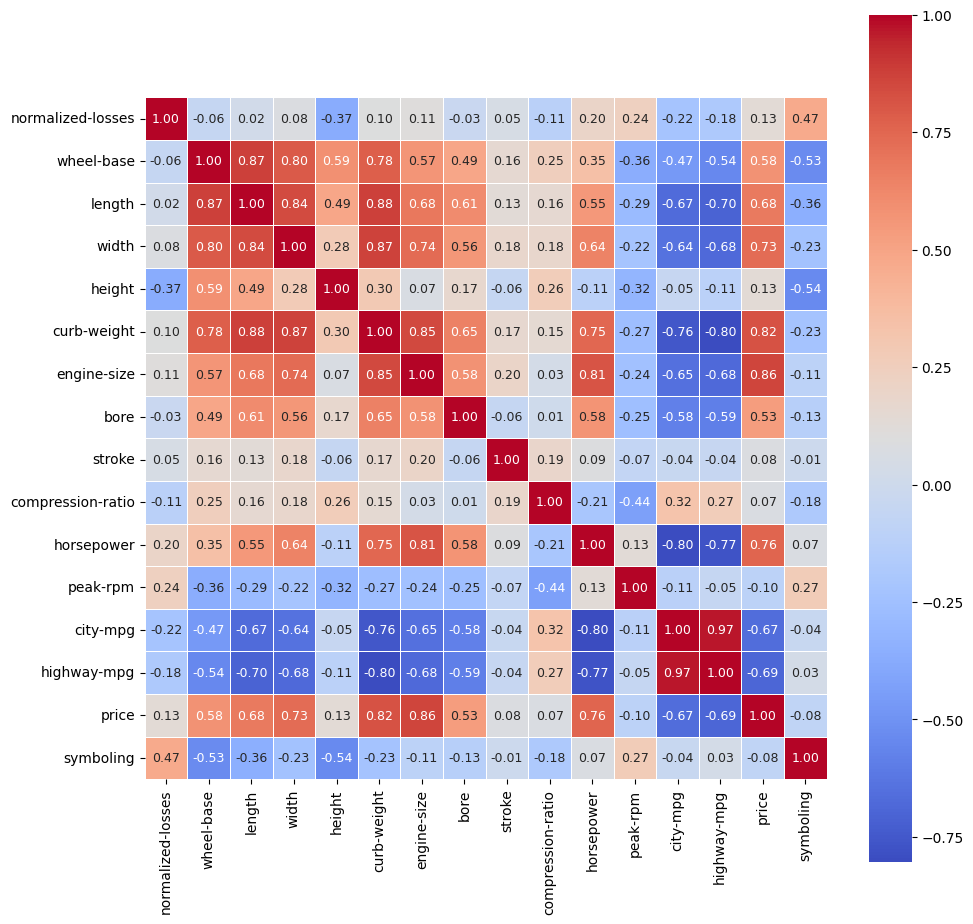

In [3]:
#-- ver si tienen datos faltantes --
values = {'horsepower': df['horsepower'].mean(),
          'price': df['price'].mean()}
values = {'normalized-losses': df['normalized-losses'].mean(),
          'bore': df['bore'].mean(),
          'stroke': df['stroke'].mean(),
          'horsepower': df['horsepower'].mean(),
          'peak-rpm': df['peak-rpm'].mean(),
          'price': df['price'].mean()}

# reemplaza valores nulos por los indicados en el diccionario values
df = df.fillna(value=values)

#-- seleccionar los atributos numéricos --
df = df.select_dtypes(include = np.number)

# imprime valores nulos
print(df.isnull().sum())

#nomAtrib = np.array(df.columns.values).reshape(-1,1)



# Imprime matriz de correclacion
corr = df.corr()
plt.figure(figsize=(11,11))
sns.heatmap(corr, square=True,  annot=True, linewidths=.5, cmap='coolwarm', annot_kws={'fontsize':9}, fmt='.2f')



### Preparación de datos para entrenamiento de neurona

Normalización: 1

Tiempo total de entrenamiento: 10.7055 segundos
Tiempo promedio por ejecución:  0.5353 segundos



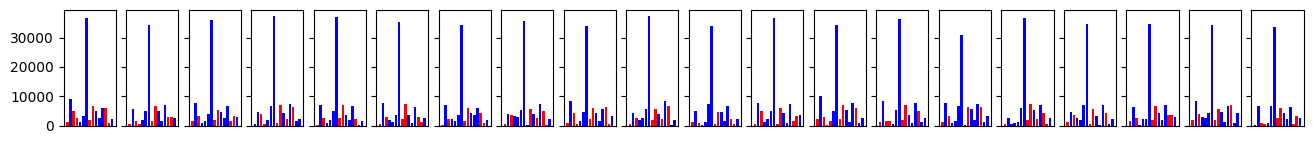

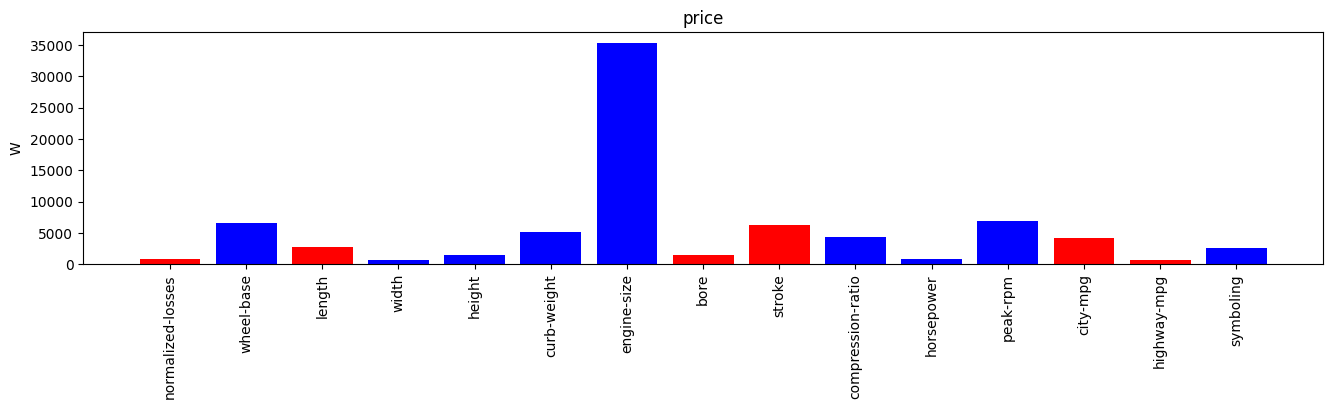

In [6]:
import time  # <-- Asegúrate de importarlo

# nomPred contiene el nombre de la columna objetivo (price, volume):
nomPred = "price"

# --- Preparación de datos ---
T = df[[nomPred]].values
Ejemplos = df.drop(columns=[nomPred]).values
nomCols = df.drop(columns=[nomPred]).columns.tolist()

alfa = 0.05
MAX_ITE = 200
CotaError = 10e-04
CANT_PLOTS = 20
normalizarEntrada = 1

# --- Normalización ---
if normalizarEntrada == 1:
    normalizador = preprocessing.MinMaxScaler()
    X = normalizador.fit_transform(Ejemplos)
elif normalizarEntrada == 2:
    normalizador = preprocessing.StandardScaler()
    X = normalizador.fit_transform(Ejemplos)
else:
    X = Ejemplos

w_acc = np.zeros(len(nomCols))
fig, subs = plt.subplots(1, CANT_PLOTS, sharex='col', sharey='row', figsize=(16, 1.5))
print('Normalización: %d' % normalizarEntrada)

# --- Medición de tiempo ---
start_time = time.time()

for i in range(CANT_PLOTS):
    # Reordenar al azar
    indices = np.random.permutation(len(X))
    X_shuffled = X[indices]
    T_shuffled = T[indices]

    modelo = NeuronaLineal(alpha=alfa, n_iter=MAX_ITE, cotaE=CotaError)
    modelo.fit(X_shuffled, T_shuffled)

    w_acc += modelo.w_

    colores = ['blue' if valor >= 0 else 'red' for valor in modelo.w_]
    subs[i].bar(np.arange(len(modelo.w_)), np.abs(modelo.w_), color=colores)
    subs[i].set_xticks([])

end_time = time.time()
total_time = end_time - start_time
avg_time_per_run = total_time / CANT_PLOTS

print(f"\nTiempo total de entrenamiento: {total_time:7.4f} segundos")
print(f"Tiempo promedio por ejecución: {avg_time_per_run:7.4f} segundos\n")

# --- Gráfico final de pesos promedio ---
w_prom = w_acc / CANT_PLOTS
colores = ['blue' if valor >= 0 else 'red' for valor in w_prom]
barras = np.abs(w_prom)

plt.figure(figsize=(16, 4))
N = len(barras)
plt.bar(np.arange(N), barras, color=colores)
plt.title(nomPred)
plt.ylabel('W')
plt.xticks(np.arange(N), nomCols, rotation='vertical')
plt.subplots_adjust(bottom=0.3)
plt.show()